I implemented a program for input vector of $2^n$ size with data of $m$ bit binary representation, i.e. the bonus part of task 1, which is presented here in the Jupyter notebook. For the solution to the main task in Task 1, simply use an input vector of $[1, 5, 7, 10]$.

# Quantum random access memory (QRAM)

The program makes use of QRAM. Throughout this notebook, the qubits used in the quantum circuit will be divided into two categories: address qubits and data qubits.

# Issue and workaround

For an input vector of $2^n$ size with data of $m$ bit binary representation, I first tried to solve the problem using a quantum circuit of $n$ address qubits and $m$ data qubits. However, I find that the implementation fails when the solution is composed of $2^{n-1}$ address states out of $2^n$ possible address states, such as when the input vector is $[1, 5, 7, 10]$. In cases like this, where we are selecting for half of the possible states, the rotation angle is $\pi / 4$ [1] and the success probability becomes only 50% [2].

To circumvent this issue, I instead used $n+1$ address qubits and $m$ data qubits. The extra $2^n$ address states arising from the extra address qubit have its corresponding data qubit state hold the binary represetion of the integer 0, which has no alternating bits. At the end, when looking for the solution, the actual address states will have an extra $|0>$ from the extra address qubit which can be traced out. 

# Algorithm description

The general concept behind the quantum algorithm is captured in Fig. 1. 

For an input vector of $2^n$ size with data of $m$ bit binary representation, quantum circuit of $n+1$ address qubits and $m$ data qubits is used. The address qubits are first put into uniform superposition to faciliate the creation of QRAM. After creating  QRAM, an oracle is added to the circuit that marks the desired states by flipping the phase of the desired states. Then, the QRAM operation (i.e. the $qram$ function) is applied again, which will transform the data qubits back to the $|0>$ state due to the reversibility of quantum gates. Lastly, a Grover diffuser is applied to the address qubits to amplify the amplitude of the states desired and the output state of the whole circuit is simply
\begin{equation} \tag{1}
|0> \otimes () \otimes |0>.
\end{equation}
where the first $|0>$ comes from the extra address qubit. The empty bracket in Eq. (1) represents the output state of the address qubits, which is the solution to the problem statement.

As an example, when the input vector is $[1, 5, 7, 10]$, the output state of the circuit should be 
\begin{equation} \tag{2}
|0>\otimes \bigg[\frac{1}{\sqrt{2}}(|01>+|11>)\bigg] \otimes |0000>,
\end{equation}
By tracing out $|0>$ from the extra address qubit and $|0000>$ from the data qubits, the solution of $\frac{1}{\sqrt{2}}(|01>+|11>)$ is obtained.

<center><b> Figure 1: Algorithm scheme </b></center>

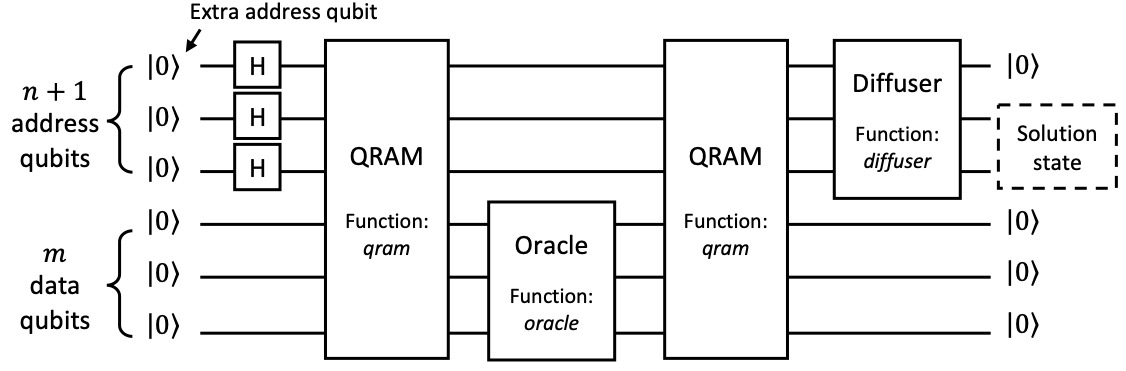

# Oracle

The oracle implemented (see $oracle$ function) finds the states with alternating bits and flips their phase. The oracle first flips alternate data qubits with the Pauli-X gate. Therefore, if a state has alternating bits, it ends up being all 0s $|00...0>$ or all 1s $|11...1>$ and, if a state does not have alternating bits, it ends up with a mixture of 0s and 1s. Based on the fact that only alternating bit states end up as $|00...0>$ or $|11...1>$, one can uses a multi-controlled Z gate, which only flips the phase of $|11...1>$. After flipping alternate data qubits, the oracle does the following:
<ol>
    <li> Applies a multi-controlled Z gate across the data qubits, $|00...0> \rightarrow |00...0>$ and $|11...1> \rightarrow -|11...1>$.</li>
    <li> Flips all the data qubits, $|00...0> \rightarrow |11...1>$ and $-|11...1> \rightarrow -|00...0>$.</li>
    <li> Applies another multi-controlled Z gate across the data qubits, $|11...1> \rightarrow -|11...1>$ and $-|00...0> \rightarrow -|00...0>$.</li>
    <li> Flips all the data qubits back, $-|11...1> \rightarrow -|00...0>$ and $-|00...0> \rightarrow -|11...1>$.</li>
</ol>
Lastly, the oracle flips back the alternate data qubits back to their original state and the final result is the states with alternating bits are marked with a negative phase flip. 

# Diffuser

Since the solution only pertains the address qubit states, the diffuser implemented (function $diffuser$) only acts on the address qubits. The general Grover diffuser $U$ for $N$ number of qubits is given by [3]
\begin{equation} \tag{3}
U =  - H^{\otimes N} X^{\otimes N} (MCZ) X^{\otimes N} H^{\otimes N},
\end{equation}
where $MCZ$ is the multi-controlled Z gate applied across the $N$ qubits. The function $diffuser$ implements the gates in Eq. 3 and as such adds a global phase of -1 to the state of the circuit.

# Limitation

There is one scenario where the codes below won't produce the correct results; that is, when every element in the input vector has alternating bits. This is because $n+1$ address qubits are used when there are $2^n$ addresses. When every element in the input vector has alternating bits, we are selecting for ($\frac{2^{n+1}}{2^n} = \frac{1}{2}$) half of the $2^{n+1}$ possible address states, which will run into the issue described previously. However, I consider the scenario where every element in the input vector has alternating bits to be trivial since the correct solution would be just all the possible states given $n$ addresses so no selection is actually needed. Therefore, I leave the codes as they are since, as far as I know, they should work for most cases except for the trivial case. 

# Codes

In [1]:
from qiskit import (QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, assemble)
import numpy as np

In [2]:
def toBin(vector, length):
    """Converts the integers in the vector to binary representation.
    Parameters: length - the number of bits in the binary representation."""
    
    sz = np.size(vector)
    
    output = []
    
    for i in range(sz):
        output.append(bin(vector[i])[2:].rjust(length, "0"))
        
    return output

In [3]:
def indexing(string):
    """Returns two lists containing the indices of the 0s and 1s appearing in the binary string."""
    
    li0 = []
    li1 = []
    
    for i in range(len(string)):
        if string[i] == '0':
            li0.append(i)
        else:
            li1.append(i)
            
    return (li0, li1)

In [4]:
def qram(circuit, address, data, address_index, data_index):
    """Creates quantum random access memory (qRAM) of the input vector.
    Parameters: address_index - contains the indices of the address qubits that are in |0>.
                data_index - contains the indices of the data qubits that needs to be transformed to |1>."""
    
    for i in range(np.size(address_index)):
        for aj in address_index[i]:
            circuit.x(address[aj])
        
        for dj in data_index[i]:
            circuit.mct(address, data[dj])
    
        for aj in address_index[i]:
            circuit.x(address[aj])

In [5]:
def multi_z(circuit, control, target):
    """Applies a multi-controlled Z gate across the control and target qubits."""
    
    circuit.h(target)
    circuit.mcx(control, target)
    circuit.h(target)

In [6]:
def flip_phase(circuit, register):
    """Flips the phase of the state if the state is |00...0> or |11..1>."""
    
    multi_z(circuit, register[:-1], register[-1])
    circuit.x(register)
    multi_z(circuit, register[:-1], register[-1])
    circuit.x(register)

In [7]:
def alternate(circuit, register, m):
    """Flips alternate qubits of a m-qubit register"""
    
    for i in range(0, m, 2):
        circuit.x(register[i])

In [8]:
def oracle(circuit, register, m):
    """Grover oracle to find the states with alternating bits and flips their phase."""
    
    alternate(circuit, register, m)
    flip_phase(circuit, register)
    alternate(circuit, register, m)

In [9]:
def diffuser(circuit, register):
    """General Grover diffuser, assumes register contains all the qubits to diffuse over 
    (i.e. assumes register is the address qubit register). 
    Side note: this diffuser implementation adds a global phase of -1."""
    
    circuit.h(register)
    circuit.x(register)
    multi_z(circuit, register[:-1], register[-1])
    circuit.x(register)
    circuit.h(register)

In [10]:
def partial(statevector, n_1, n_2, trace_out = 1):
    """Takes in a statevector spanning 2^{n_1} tensor 2^{n_2} Hilbert space with the states in the 2^{n_2} or 2^{n_1}
    subspace being in the |0> state of that space. Returns the state in the 2^{n_1} or 2^{n_2} subspace.
    Parameters: trace_out = 1 indicates that the state in the 2^{n_2} subspace is in the |0> state and is to be traced out. 
                trace_out = 0 indicates that the state in the 2^{n_1} subspace is in the |0> state and is to be traced out."""
    
    if trace_out == 1:
        sz = np.size(statevector)
    
        output = np.zeros(2**n_1).astype("complex")
        
        for i in range(int(sz / (2**n_2))):
            output[i] = statevector[i * 2**n_2]
            
    elif trace_out == 0:
        output = statevector[0:int(2**n_2)]
        
    return output

In [11]:
def prb_graph(statevector, n, title):
    """Takes in a state vector of n qubits and plots a bar graph of the corresponding probability of each state."""
    
    import matplotlib.pyplot as plt
    
    state_arr = np.arange(np.size(statevector))
    state_li = []
    prb_arr = np.zeros(np.size(statevector))
    
    for i in range(np.size(state_arr)):
        state_li.append(bin(state_arr[i])[2:].rjust(n, "0"))
        prb_arr[i] = np.square(np.real(statevector[i])) + np.square(np.imag(statevector[i]))
        
    bars = plt.bar(state_li, prb_arr)
    
    bottom, top = plt.ylim()
    plt.ylim(bottom, top + 0.02)
    
    for bar in bars:
        y = bar.get_height()
        plt.text(bar.get_x(), y + 0.01, '{:.3f}'.format(y))
        
        
    plt.title(title)
    
    if n > 3:
        plt.xticks(rotation = 90)
    
    plt.xlabel("State")
    plt.ylabel("Probability")

In [12]:
# for the main task of Task 1
input_vector = [1, 5, 7, 10]
expected = np.array([0 , 1, 0, 1]) / np.sqrt(2)

# # other input vectors for testing bonus part
# input_vector = [2, 21, 42, 5]
# expected = np.array([0 , 1, 1, 0]) / np.sqrt(2)

# input_vector = [1, 5, 4, 2]
# expected = np.array([0 , 1, 0, 1]) / np.sqrt(2)

# input_vector = [1, 10, 7, 21, 21, 2, 8, 10]
# expected = np.array([0 , 1, 0, 1, 1, 0, 0, 1]) / np.sqrt(4)

# input_vector = [10, 9, 7, 6, 12, 2, 21, 4, 1, 2, 19, 4, 5, 18, 7, 15]
# expected = np.array([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]) / np.sqrt(2)

# input_vector = [10, 9, 32, 6, 85, 2, 3, 42, 1, 5, 19, 2, 85, 18, 7, 15]
# expected = np.array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]) / np.sqrt(3)

In [13]:
# maximum number bits m is given by the number of bits of the largest element
m = len(bin(np.max(input_vector))[2:])

sz = np.size(input_vector)

n = int(np.log(sz) / np.log(2))

# adds one more address qubit
pseudo_n = n + 1
        
# address array after including the extra address qubit
p_address = np.arange(int(2**pseudo_n))
   
# converts to binary representation
p_address_binary = toBin(p_address, pseudo_n)

p_input = input_vector.copy()

# adds the integer 0 to data for the extra address qubit
for i in range(int(2**pseudo_n) - sz):
    p_input.append(0)

# converts to binary representation
p_data = toBin(p_input, m)

# lists to store locations of 0s and 1s of the binary strings
data_0 = []
data_1 = []

address_0 = []
address_1 = []
    
# finding the occurences of 0s and 1s in both address and data binary strings
for (address_string, data_string) in zip(p_address_binary, p_data):
        (a0, a1) = indexing(address_string)
        (d0, d1) = indexing(data_string)

        address_0.append(a0)
        address_1.append(a1)
        
        data_0.append(d0)
        data_1.append(d1)

In [14]:
address = QuantumRegister(pseudo_n)
data = QuantumRegister(m)

qc = QuantumCircuit(address, data)

# uniform superposition over address qubits
qc.h(address)

# calculating the number of Grover iterations needed
try:
    number = np.count_nonzero(expected)
    iterations = int(np.ceil(np.pi / 4 * np.sqrt(2**pseudo_n / number))) - 1

# in case no expected solution given
except:
    iterations = 1

for it in range(iterations):
    qram(qc, address, data, address_0, data_1)

    oracle(qc, data, m)

    qram(qc, address, data, address_0, data_1)

    diffuser(qc, address)

# Qiskit ordering is in reverse
qc = qc.reverse_bits()

/Users/tsai/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [15]:
# getting state vector
sim = Aer.get_backend('qasm_simulator')

qc_sim = qc.copy()
qc_sim.save_statevector()

qj = assemble(qc_sim)
result = sim.run(qj).result()

# state vector of the entire quantum circuit
statevec = result.get_statevector()

# trace out the data qubit states which is in |0>
statevec = partial(statevec, pseudo_n, m)

# trace out the extra address qubit that is in |0>
statevec = partial(statevec, 1, n, trace_out = 0)

In [16]:
print("Output state vector is \n", statevec, ".")

try:
    print("Expected state vector is \n", expected, ".")
except:
    pass

Output state vector is 
 [-5.55111512e-17+6.49467042e-17j -7.07106781e-01+4.97924732e-16j
 -5.55111512e-17+2.16489014e-17j -7.07106781e-01+5.41222535e-16j] .
Expected state vector is 
 [0.         0.70710678 0.         0.70710678] .


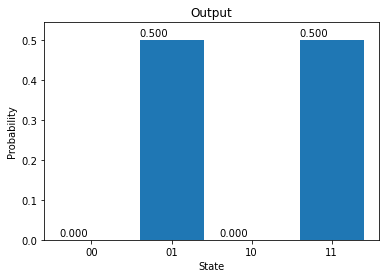

In [17]:
prb_graph(statevec, n, "Output")

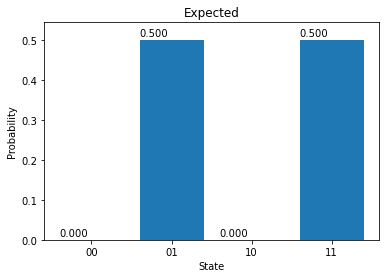

In [18]:
try:
    prb_graph(expected, n, "Expected")
except:
    print("Expected solution not given.")

# Concluding remarks

As can be seen, the program does not produce the exact expected probability for some of the example input vectors. This should be expected since Grover's algorithm does not guarantee success all the time and depends on the number of solution states as well as the number of possible address states [3].

While the program produced acceptable results, there could have been a more elegant way to go about the task. An extra address qubit is used in order to circument the issue where the solution is composed of $2^{n-1}$ address states out of $2^n$ possible address states. There could have been other methods to solve the task while still adhering to $n$ address qubits instead of using $n+1$ address qubits. There were not enought time to successfuly found those methods.

# Biblography
<ol>
    <li>Michael A. Nielsen and Isaac L. Chuang. <i>Quantum Computation and Quantum
        Information</i>. Cambridge University Press, 2000.</li>
    <li>Ahemd Younes. Strength and Weakness in Grover’s Quantum Search
        Algorithm</li>
    <li>"<i>Grover's algorithm</i>". Qiskit Texbook. https://qiskit.org/textbook/ch-algorithms/grover.html</li>
    <li>Christof Zalka. Grover’s quantum searching algorithm is optimal. <i>Phys. Rev. A</i>, 60(4):2746-2751, 1999</li>
</ol>